In [50]:
from dataset.datasets import get_dataset
from torch_geometric.datasets import WebKB, Planetoid, KarateClub, Airports
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.utils import is_undirected, get_laplacian, to_undirected, to_dense_adj
import torch

In [51]:
def get_lap(dataset):
    data = dataset[0]
    edge_index = to_undirected((data.edge_index))
    assert is_undirected(edge_index)

    lap = get_laplacian(edge_index, normalization="sym")
    lap = to_dense_adj(lap[0], edge_attr=lap[1])
    return data, lap

In [52]:
def eigen_decompose(lap):
    e, v = torch.linalg.eigh(lap)
    e = e.squeeze()
    v = v.squeeze()
    return e, v

In [136]:
def find_eigen_representaion(v, y):
    best_dist = float('inf')
    best_i = 0
    best_j = 0
    num_classes = y.max() + 1
    for i in range(1, v.shape[0]):
        for j in range(1, v.shape[0]):
            if i == j:
                continue
            embed = v[:, [i, j]]
            dist_1 = []
            dist_2 = [0.]
            for c in range(num_classes):
                if (y == c).count_nonzero() > 1:
                    dist_1.append(torch.pdist(embed[y == c]).mean())
                    for d in range(num_classes):
                        if c != d:
                            dist_2.append(torch.cdist(embed[y == c], embed[y == d]).mean()/num_classes)
            dist = torch.tensor(dist_1).mean() - torch.tensor(dist_2).mean()

            if best_dist > dist:
                best_dist = dist
                print(i, j)
                best_i = i
                best_j = j
    return best_i, best_j

In [113]:
def plot_data_points(i, j, y):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(projection='3d')
    ax = v[:,i]
    ay = v[:,j]
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    plt.scatter(ax, ay, s=50, c=[colours[c] for c in y])
    plt.show()

In [108]:
name = 'Wisconsin'
path = osp.join('..', 'data', name)
dataset = WebKB(path, name)
data, lap = get_lap(dataset)

In [109]:
e, v = eigen_decompose(lap)

In [110]:
i, j = find_eigen_representaion(v, data.y)

In [119]:
print(i, j)

44 207


<Figure size 432x288 with 0 Axes>

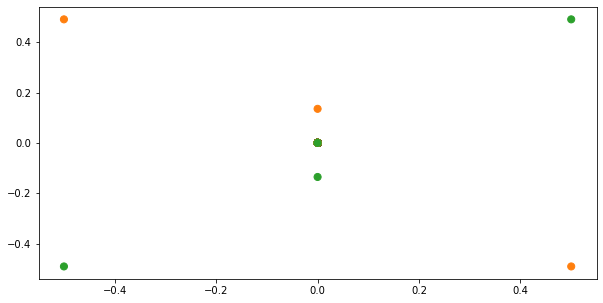

In [120]:
plot_data_points(i, j, data.y)

<Figure size 432x288 with 0 Axes>

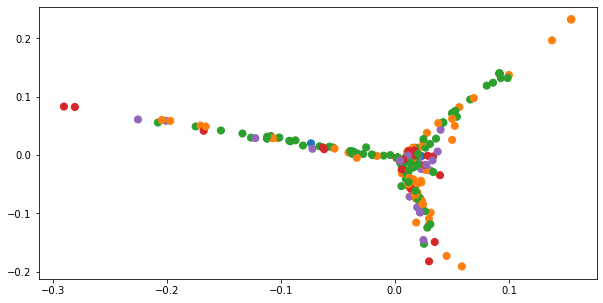

In [121]:
plot_data_points(1, 2, data.y)

In [144]:
name = 'Europe'
path = osp.join('..', 'data', name)
dataset = Airports(path, name)
data, lap = get_lap(dataset)

Processing...
Done!


In [145]:
e, v = eigen_decompose(lap)

In [146]:
i, j = find_eigen_representaion(v, data.y)

1 2
1 3
1 5
1 366
3 366
3 382
208 366
208 382
366 382


<Figure size 432x288 with 0 Axes>

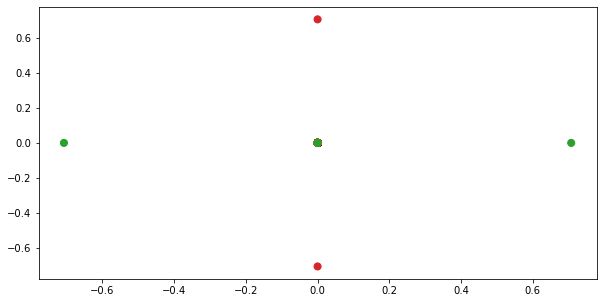

In [149]:
plot_data_points(i, j, data.y)

<Figure size 432x288 with 0 Axes>

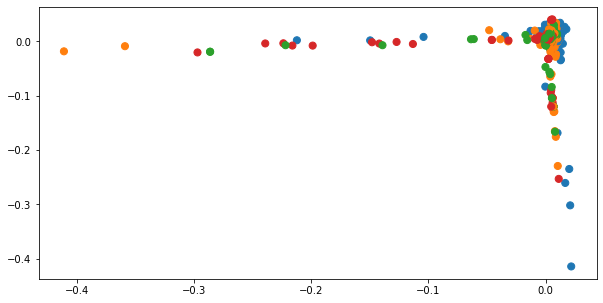

In [150]:
plot_data_points(1, 2, data.y)

In [79]:
i

65

In [80]:
j

67

In [43]:
data.y.shape


torch.Size([34])